In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


# UK Prediction - Leeds City

Now we will rerun our experiment with added locational attributes to see if it improves our model.

In [2]:
# new file containing rows with our focused area of Dublin found through exploratory analysis
irl = pd.read_csv('leefourfeatures.csv', index_col = 'Unnamed: 0')

In [3]:
irl.shape

(40943, 23)

In [4]:
irl['County'].value_counts()

WEST YORKSHIRE     37826
NORTH YORKSHIRE     3117
Name: County, dtype: int64

In [5]:
irl.drop(columns = ['Transaction unique identifier', 'Town/City', 'Add1', 'HouseNum', 'geocode'], inplace = True)

In [6]:
irl = irl.dropna()

In [7]:
irl.shape

(40925, 18)

In [8]:
dt = list(irl['Postcode'])
ps = []
for i in range(len(dt)):
    strg = dt[i][:4]
    ps.append(strg)

In [9]:
ps[0]

'LS25'

In [10]:
irl['Postcode'] = ps

In [11]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [12]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price'])

In [13]:
encoder = TargetEncoder()
irl['District'] = encoder.fit_transform(irl['District'], irl['Price'])

In [14]:
encoder = TargetEncoder()
irl['Add3'] = encoder.fit_transform(irl['Add3'], irl['Price'])

In [15]:
encoder = TargetEncoder()
irl['Postcode'] = encoder.fit_transform(irl['Postcode'], irl['Price'])

In [16]:
encoder = TargetEncoder()
irl['Add2'] = encoder.fit_transform(irl['Add2'], irl['Price'])

In [17]:
#categorical data
categorical_cols = ['Property Type', 'Old/New', 'Duration', 'PPDCategory Type'] 

#import pandas as pd
df = pd.get_dummies(irl, columns = categorical_cols)

In [18]:
df.columns

Index(['Price', 'Postcode', 'Add2', 'Add3', 'District', 'County', 'Month',
       'Year', 'Latitude', 'Longitude', 'PrimaryDistance', 'SecondaryDistance',
       'CityCenterDist', 'ClosestPitch', 'Property Type_D', 'Property Type_F',
       'Property Type_O', 'Property Type_S', 'Property Type_T', 'Old/New_N',
       'Old/New_Y', 'Duration_F', 'Duration_L', 'PPDCategory Type_A',
       'PPDCategory Type_B'],
      dtype='object')

In [19]:
irl = df

In [20]:
irl.head()

,Price,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,...,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B
0,210000,217630.968385,258739.196082,224647.939686,235254.601253,256030.890142,5,2017,53.79569,-1.24147,...,0,0,0,0,1,0,1,0,1,0
1,180000,217630.968385,205494.667996,224647.939686,235254.601253,256030.890142,4,2017,53.79803,-1.25588,...,0,0,0,0,1,0,1,0,1,0
2,142500,230484.114908,243485.169492,202537.379451,230202.181727,230200.817112,12,2017,53.85906,-1.68457,...,1,0,0,0,0,1,0,1,1,0
3,102000,278963.485067,186296.875000,278963.485067,230202.181727,230200.817112,12,2017,53.84793,-1.63152,...,1,0,0,0,1,0,0,1,1,0
4,250000,230484.114908,254714.655953,202537.379451,230202.181727,230200.817112,9,2017,53.85909,-1.68380,...,0,0,1,0,0,1,1,0,1,0


In [21]:
irl['PriceLog'] = np.log(irl['Price'])

In [22]:
irl.drop(columns = ['Price'], inplace = True)

In [23]:
irl.shape

(40925, 25)

### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [24]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [25]:
specific21[specific21['Year'] == 2021].head()

,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,PrimaryDistance,...,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,PriceLog
36826,173445.626947,300787.500000,168385.293057,230202.181727,230200.817112,7,2021,53.74855,-1.58847,0.464833,...,0,0,0,1,0,1,0,1,0,12.823148
36827,172087.522876,123703.049895,145592.471125,230202.181727,230200.817112,11,2021,53.80770,-1.61968,0.096163,...,0,0,1,1,0,1,0,1,0,11.891362
36828,278963.485067,507271.771193,278963.485067,230202.181727,230200.817112,7,2021,53.83972,-1.65612,0.269080,...,0,0,0,1,0,1,0,1,0,13.681979
36829,400420.138054,328417.871528,329438.255034,230202.181727,230200.817112,8,2021,53.85191,-1.47258,0.141377,...,0,0,1,1,0,1,0,1,0,11.982929
36830,210307.345368,106687.514620,213710.799763,230202.181727,230200.817112,7,2021,53.72532,-1.44393,3.021215,...,0,0,1,1,0,1,0,1,0,11.652687


In [26]:
specific21.shape[0]

22523

In [27]:
train_21 = specific21[specific21['Year'] < 2021]

In [28]:
#train_21 = train_21.sample(n = 80000)
train_21.head()

,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,PrimaryDistance,...,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,PriceLog
2546,278963.485067,271984.615384,278963.485067,230202.181727,230200.817112,11,2018,53.831194,-1.666523,1.225576,...,0,0,1,1,0,1,0,1,0,12.323856
2547,273434.133215,173987.759494,206134.230906,230202.181727,230200.817112,11,2018,53.829730,-1.451610,0.208411,...,0,0,0,1,0,1,0,1,0,12.472276
2548,290683.041423,230946.422959,287276.125746,230202.181727,230200.817112,11,2018,53.876410,-1.713510,0.164222,...,0,1,0,1,0,1,0,1,0,12.348006
2549,273434.133215,163597.181818,206134.230906,230202.181727,230200.817112,8,2018,53.828700,-1.449140,0.355955,...,0,1,0,1,0,1,0,1,0,12.278393
2550,173445.626947,140210.000515,168385.293057,230202.181727,230200.817112,5,2018,53.752140,-1.606300,0.181792,...,0,0,1,1,0,1,0,1,0,11.630709


In [29]:
test_21 = specific21[specific21['Year'] == 2021]

In [30]:
x_train_21 = train_21.loc[:, train_21.columns != 'PriceLog']
y_train_21 = train_21['PriceLog']

In [31]:
test_21.head()

,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,PrimaryDistance,...,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,PriceLog
36826,173445.626947,300787.500000,168385.293057,230202.181727,230200.817112,7,2021,53.74855,-1.58847,0.464833,...,0,0,0,1,0,1,0,1,0,12.823148
36827,172087.522876,123703.049895,145592.471125,230202.181727,230200.817112,11,2021,53.80770,-1.61968,0.096163,...,0,0,1,1,0,1,0,1,0,11.891362
36828,278963.485067,507271.771193,278963.485067,230202.181727,230200.817112,7,2021,53.83972,-1.65612,0.269080,...,0,0,0,1,0,1,0,1,0,13.681979
36829,400420.138054,328417.871528,329438.255034,230202.181727,230200.817112,8,2021,53.85191,-1.47258,0.141377,...,0,0,1,1,0,1,0,1,0,11.982929
36830,210307.345368,106687.514620,213710.799763,230202.181727,230200.817112,7,2021,53.72532,-1.44393,3.021215,...,0,0,1,1,0,1,0,1,0,11.652687


In [32]:
x_test_21 = test_21.loc[:, test_21.columns != 'PriceLog']
y_test_21 = test_21['PriceLog']

In [33]:
## explain_level gives information on feature importance when given value 1 or 2
automl1 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl1.fit(x_train_21, y_train_21)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.571987 trained in 0.48 seconds
2_DecisionTree rmse 0.404724 trained in 22.25 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.269216 trained in 58.77 seconds
4_Default_NeuralNetwork rmse 0.338143 trained in 2.22 seconds
5_Default_RandomForest rmse 0.358237 trained in 12.77 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.267139 trained in 0.64 seconds
AutoML fit time: 924.01 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [34]:
# calculated values
y_predicted_21 = automl1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 0.11458671825415799


In [35]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared = False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 0.338506600015654


In [36]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.35776069197501204


In [37]:
acc1 = accuracy_threshold(y_test_21, y_predicted_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6441614608361365


In [38]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1521584746816484


In [39]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.017440273762698747


In [40]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [41]:
#cnames = ['Actual', 'Predicted']
#dfreal1 = pd.DataFrame(columns = cnames)
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020 predictions

In [42]:
specific20 = irl[irl['Year'] > 2016]

In [43]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [44]:
x_train_20 = train_20.loc[:, train_20.columns != 'PriceLog']
y_train_20 = train_20['PriceLog']

In [45]:
x_test_20 = test_20.loc[:, test_20.columns != 'PriceLog']
y_test_20 = test_20['PriceLog']

In [46]:
automl2 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl2.fit(x_train_20, y_train_20)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.598174 trained in 0.7 seconds
2_DecisionTree rmse 0.424108 trained in 8.36 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.262145 trained in 40.14 seconds
4_Default_NeuralNetwork rmse 0.364557 trained in 2.87 seconds
5_Default_RandomForest rmse 0.379638 trained in 7.64 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.262145 trained in 0.32 seconds
AutoML fit time: 82.0 seconds
AutoML best model: 3_Default_Xgboost


AutoML(explain_level=2, total_time_limit=300)

In [47]:
# calculated values
y_predicted_20 = automl2.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_predicted_20)
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 0.11850981606059857


In [48]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 0.3442525469195523


In [49]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.38770511878520697


In [50]:
acc1 = accuracy_threshold(y_test_20, y_predicted_20, 0.2)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.665686994856723


In [51]:
print("Median Absolute Error:\n")
print(median_absolute_error(y_test_20, y_predicted_20))

Median Absolute Error:

0.1370892341318779


In [52]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.017240000279663627


In [53]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

In [54]:
#cnames = ['Actual', 'Predicted']
#dfreal2 = pd.DataFrame(columns = cnames)
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)
#dfreal2 = pd.concat([z1, z2], ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [55]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [56]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [57]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 0.12163906709198832


In [58]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.33181162902450745


In [59]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.5994714079769342


In [60]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16171606155148338


In [61]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3487679272696794


In [62]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.018525833898405474


In [63]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [64]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [65]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 0.12598493279498751


In [66]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34508939505265734


In [67]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.15)
print('Accuracy of properties at +- 15% of actual prices is ' + str(acc1))

Accuracy of properties at +- 15% of actual prices is 0.49277492040166543


In [68]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1559217373077768


In [69]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.35494356283075146


In [70]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.01861780766002892


In [71]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [72]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [73]:
model = AdaBoostRegressor()

In [74]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [75]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 0.2073447421465414


In [76]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.19533877943296493


In [77]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.40965881787602115


In [78]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2654447770832392


In [79]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.45535122943343553


In [80]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.02642915373280862


In [81]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [82]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [83]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 0.17867182060606726


In [84]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2601028655400441


In [85]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.5111437668381092


In [86]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20906372904615544


In [87]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4226958961310927


In [88]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.023339695291850333


In [89]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns = cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [90]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [91]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [92]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 0.11209918399204873


In [93]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3852559392603478


In [94]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6642174871418075


In [95]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14151314048891273


In [96]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3348121622522825


In [97]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.01693800584805931


In [98]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [99]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [100]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 0.11093363561099025


In [101]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3462277751081211


In [102]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6326285439692455


In [103]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15318682860942873


In [104]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3330670136939266


In [105]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.017563678159351424


In [106]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [107]:
from catboost import CatBoostRegressor

In [108]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.064845
0:	learn: 0.5737353	total: 148ms	remaining: 2m 27s
1:	learn: 0.5551178	total: 154ms	remaining: 1m 16s
2:	learn: 0.5385000	total: 160ms	remaining: 53.1s
3:	learn: 0.5233769	total: 166ms	remaining: 41.3s
4:	learn: 0.5102591	total: 172ms	remaining: 34.3s
5:	learn: 0.4980203	total: 180ms	remaining: 29.8s
6:	learn: 0.4857911	total: 187ms	remaining: 26.5s
7:	learn: 0.4746755	total: 193ms	remaining: 23.9s
8:	learn: 0.4647203	total: 198ms	remaining: 21.9s
9:	learn: 0.4548978	total: 204ms	remaining: 20.2s
10:	learn: 0.4470899	total: 210ms	remaining: 18.9s
11:	learn: 0.4394990	total: 217ms	remaining: 17.8s
12:	learn: 0.4328231	total: 223ms	remaining: 16.9s
13:	learn: 0.4263259	total: 229ms	remaining: 16.1s
14:	learn: 0.4207021	total: 234ms	remaining: 15.4s
15:	learn: 0.4155200	total: 240ms	remaining: 14.8s
16:	learn: 0.4102634	total: 246ms	remaining: 14.2s
17:	learn: 0.4052852	total: 252ms	remaining: 13.8s
18:	learn: 0.4005402	total: 258ms	remaining: 13.3s
19:	learn

168:	learn: 0.2969686	total: 1.89s	remaining: 9.3s
169:	learn: 0.2967079	total: 1.91s	remaining: 9.34s
170:	learn: 0.2961902	total: 1.94s	remaining: 9.42s
171:	learn: 0.2961127	total: 1.96s	remaining: 9.42s
172:	learn: 0.2959593	total: 1.98s	remaining: 9.44s
173:	learn: 0.2958379	total: 1.99s	remaining: 9.45s
174:	learn: 0.2957040	total: 2.01s	remaining: 9.49s
175:	learn: 0.2955037	total: 2.03s	remaining: 9.51s
176:	learn: 0.2951500	total: 2.05s	remaining: 9.52s
177:	learn: 0.2946518	total: 2.07s	remaining: 9.57s
178:	learn: 0.2944594	total: 2.1s	remaining: 9.61s
179:	learn: 0.2941458	total: 2.12s	remaining: 9.63s
180:	learn: 0.2939243	total: 2.15s	remaining: 9.74s
181:	learn: 0.2937629	total: 2.17s	remaining: 9.75s
182:	learn: 0.2935803	total: 2.19s	remaining: 9.79s
183:	learn: 0.2933966	total: 2.21s	remaining: 9.8s
184:	learn: 0.2927402	total: 2.23s	remaining: 9.83s
185:	learn: 0.2924519	total: 2.25s	remaining: 9.84s
186:	learn: 0.2921502	total: 2.27s	remaining: 9.86s
187:	learn: 0.2

335:	learn: 0.2615457	total: 3.38s	remaining: 6.68s
336:	learn: 0.2612257	total: 3.38s	remaining: 6.66s
337:	learn: 0.2611333	total: 3.39s	remaining: 6.64s
338:	learn: 0.2609813	total: 3.4s	remaining: 6.63s
339:	learn: 0.2608514	total: 3.41s	remaining: 6.62s
340:	learn: 0.2607788	total: 3.42s	remaining: 6.61s
341:	learn: 0.2606787	total: 3.42s	remaining: 6.59s
342:	learn: 0.2604581	total: 3.43s	remaining: 6.57s
343:	learn: 0.2603386	total: 3.44s	remaining: 6.55s
344:	learn: 0.2603055	total: 3.44s	remaining: 6.53s
345:	learn: 0.2601999	total: 3.45s	remaining: 6.52s
346:	learn: 0.2601282	total: 3.46s	remaining: 6.5s
347:	learn: 0.2599686	total: 3.46s	remaining: 6.48s
348:	learn: 0.2597336	total: 3.47s	remaining: 6.47s
349:	learn: 0.2596756	total: 3.47s	remaining: 6.45s
350:	learn: 0.2595525	total: 3.48s	remaining: 6.43s
351:	learn: 0.2594797	total: 3.48s	remaining: 6.41s
352:	learn: 0.2594265	total: 3.49s	remaining: 6.4s
353:	learn: 0.2590679	total: 3.5s	remaining: 6.38s
354:	learn: 0.25

521:	learn: 0.2399877	total: 4.66s	remaining: 4.27s
522:	learn: 0.2398163	total: 4.67s	remaining: 4.26s
523:	learn: 0.2397212	total: 4.67s	remaining: 4.25s
524:	learn: 0.2396694	total: 4.68s	remaining: 4.23s
525:	learn: 0.2395676	total: 4.68s	remaining: 4.22s
526:	learn: 0.2393147	total: 4.69s	remaining: 4.21s
527:	learn: 0.2392576	total: 4.7s	remaining: 4.2s
528:	learn: 0.2391978	total: 4.7s	remaining: 4.19s
529:	learn: 0.2391590	total: 4.71s	remaining: 4.17s
530:	learn: 0.2390693	total: 4.71s	remaining: 4.16s
531:	learn: 0.2389315	total: 4.72s	remaining: 4.16s
532:	learn: 0.2388478	total: 4.73s	remaining: 4.14s
533:	learn: 0.2388002	total: 4.74s	remaining: 4.13s
534:	learn: 0.2387531	total: 4.74s	remaining: 4.12s
535:	learn: 0.2386471	total: 4.75s	remaining: 4.11s
536:	learn: 0.2385833	total: 4.75s	remaining: 4.1s
537:	learn: 0.2384844	total: 4.76s	remaining: 4.09s
538:	learn: 0.2384250	total: 4.76s	remaining: 4.08s
539:	learn: 0.2383511	total: 4.77s	remaining: 4.06s
540:	learn: 0.23

696:	learn: 0.2251760	total: 5.78s	remaining: 2.51s
697:	learn: 0.2251153	total: 5.78s	remaining: 2.5s
698:	learn: 0.2250223	total: 5.79s	remaining: 2.49s
699:	learn: 0.2249704	total: 5.79s	remaining: 2.48s
700:	learn: 0.2248782	total: 5.8s	remaining: 2.47s
701:	learn: 0.2247906	total: 5.8s	remaining: 2.46s
702:	learn: 0.2247364	total: 5.81s	remaining: 2.46s
703:	learn: 0.2246602	total: 5.82s	remaining: 2.45s
704:	learn: 0.2245581	total: 5.83s	remaining: 2.44s
705:	learn: 0.2245004	total: 5.83s	remaining: 2.43s
706:	learn: 0.2244422	total: 5.84s	remaining: 2.42s
707:	learn: 0.2243540	total: 5.85s	remaining: 2.41s
708:	learn: 0.2242161	total: 5.86s	remaining: 2.4s
709:	learn: 0.2241012	total: 5.86s	remaining: 2.39s
710:	learn: 0.2240530	total: 5.87s	remaining: 2.38s
711:	learn: 0.2239443	total: 5.87s	remaining: 2.38s
712:	learn: 0.2238533	total: 5.88s	remaining: 2.37s
713:	learn: 0.2238048	total: 5.89s	remaining: 2.36s
714:	learn: 0.2237475	total: 5.9s	remaining: 2.35s
715:	learn: 0.223

871:	learn: 0.2138363	total: 6.9s	remaining: 1.01s
872:	learn: 0.2137893	total: 6.91s	remaining: 1s
873:	learn: 0.2137170	total: 6.92s	remaining: 998ms
874:	learn: 0.2136793	total: 6.93s	remaining: 990ms
875:	learn: 0.2136468	total: 6.93s	remaining: 981ms
876:	learn: 0.2136055	total: 6.94s	remaining: 973ms
877:	learn: 0.2134729	total: 6.95s	remaining: 965ms
878:	learn: 0.2134177	total: 6.95s	remaining: 957ms
879:	learn: 0.2133395	total: 6.96s	remaining: 949ms
880:	learn: 0.2132863	total: 6.96s	remaining: 940ms
881:	learn: 0.2132520	total: 6.97s	remaining: 933ms
882:	learn: 0.2131638	total: 6.98s	remaining: 925ms
883:	learn: 0.2131235	total: 6.99s	remaining: 917ms
884:	learn: 0.2130549	total: 7s	remaining: 909ms
885:	learn: 0.2129938	total: 7s	remaining: 901ms
886:	learn: 0.2129562	total: 7.01s	remaining: 893ms
887:	learn: 0.2128926	total: 7.02s	remaining: 886ms
888:	learn: 0.2128269	total: 7.04s	remaining: 879ms
889:	learn: 0.2127737	total: 7.05s	remaining: 872ms
890:	learn: 0.2126848	

In [109]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 0.11061525849411423


In [110]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.36304661220567036


In [111]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14761660435404475


In [112]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.33258872274043594


In [113]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.01710188569881227


In [114]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [115]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.065288
0:	learn: 0.5701949	total: 6.38ms	remaining: 6.37s
1:	learn: 0.5512767	total: 12.4ms	remaining: 6.19s
2:	learn: 0.5347131	total: 18.4ms	remaining: 6.13s
3:	learn: 0.5193758	total: 24.2ms	remaining: 6.04s
4:	learn: 0.5061351	total: 31.3ms	remaining: 6.22s
5:	learn: 0.4935935	total: 40.1ms	remaining: 6.64s
6:	learn: 0.4810446	total: 47.7ms	remaining: 6.76s
7:	learn: 0.4700712	total: 54ms	remaining: 6.7s
8:	learn: 0.4606310	total: 61.8ms	remaining: 6.81s
9:	learn: 0.4510510	total: 69.1ms	remaining: 6.84s
10:	learn: 0.4429035	total: 76.6ms	remaining: 6.88s
11:	learn: 0.4351767	total: 84.2ms	remaining: 6.93s
12:	learn: 0.4286369	total: 91.4ms	remaining: 6.94s
13:	learn: 0.4223354	total: 98.9ms	remaining: 6.96s
14:	learn: 0.4165749	total: 108ms	remaining: 7.11s
15:	learn: 0.4105847	total: 117ms	remaining: 7.19s
16:	learn: 0.4058645	total: 124ms	remaining: 7.17s
17:	learn: 0.4016701	total: 137ms	remaining: 7.5s
18:	learn: 0.3980706	total: 146ms	remaining: 7.51s
1

165:	learn: 0.2968649	total: 1.33s	remaining: 6.67s
166:	learn: 0.2966489	total: 1.34s	remaining: 6.67s
167:	learn: 0.2964581	total: 1.35s	remaining: 6.67s
168:	learn: 0.2961595	total: 1.35s	remaining: 6.66s
169:	learn: 0.2959553	total: 1.36s	remaining: 6.66s
170:	learn: 0.2957379	total: 1.37s	remaining: 6.66s
171:	learn: 0.2953300	total: 1.38s	remaining: 6.66s
172:	learn: 0.2950983	total: 1.39s	remaining: 6.66s
173:	learn: 0.2949531	total: 1.4s	remaining: 6.66s
174:	learn: 0.2944480	total: 1.41s	remaining: 6.66s
175:	learn: 0.2941879	total: 1.42s	remaining: 6.65s
176:	learn: 0.2938843	total: 1.43s	remaining: 6.63s
177:	learn: 0.2936760	total: 1.43s	remaining: 6.61s
178:	learn: 0.2934289	total: 1.44s	remaining: 6.6s
179:	learn: 0.2931508	total: 1.44s	remaining: 6.58s
180:	learn: 0.2930257	total: 1.45s	remaining: 6.56s
181:	learn: 0.2924233	total: 1.46s	remaining: 6.55s
182:	learn: 0.2923485	total: 1.46s	remaining: 6.54s
183:	learn: 0.2918454	total: 1.47s	remaining: 6.52s
184:	learn: 0.

332:	learn: 0.2626981	total: 2.45s	remaining: 4.91s
333:	learn: 0.2625350	total: 2.46s	remaining: 4.9s
334:	learn: 0.2623882	total: 2.46s	remaining: 4.89s
335:	learn: 0.2620944	total: 2.47s	remaining: 4.88s
336:	learn: 0.2618955	total: 2.48s	remaining: 4.87s
337:	learn: 0.2617814	total: 2.48s	remaining: 4.86s
338:	learn: 0.2616642	total: 2.49s	remaining: 4.85s
339:	learn: 0.2616078	total: 2.49s	remaining: 4.84s
340:	learn: 0.2615141	total: 2.5s	remaining: 4.83s
341:	learn: 0.2611794	total: 2.51s	remaining: 4.82s
342:	learn: 0.2610170	total: 2.51s	remaining: 4.82s
343:	learn: 0.2609060	total: 2.52s	remaining: 4.8s
344:	learn: 0.2607148	total: 2.52s	remaining: 4.79s
345:	learn: 0.2606554	total: 2.53s	remaining: 4.79s
346:	learn: 0.2604473	total: 2.54s	remaining: 4.78s
347:	learn: 0.2603120	total: 2.54s	remaining: 4.77s
348:	learn: 0.2602315	total: 2.55s	remaining: 4.75s
349:	learn: 0.2601067	total: 2.56s	remaining: 4.75s
350:	learn: 0.2600471	total: 2.56s	remaining: 4.74s
351:	learn: 0.2

491:	learn: 0.2445434	total: 3.52s	remaining: 3.63s
492:	learn: 0.2444568	total: 3.52s	remaining: 3.62s
493:	learn: 0.2443093	total: 3.53s	remaining: 3.61s
494:	learn: 0.2441952	total: 3.53s	remaining: 3.6s
495:	learn: 0.2440758	total: 3.54s	remaining: 3.6s
496:	learn: 0.2437792	total: 3.55s	remaining: 3.59s
497:	learn: 0.2436632	total: 3.55s	remaining: 3.58s
498:	learn: 0.2435669	total: 3.56s	remaining: 3.58s
499:	learn: 0.2434190	total: 3.57s	remaining: 3.57s
500:	learn: 0.2432699	total: 3.58s	remaining: 3.57s
501:	learn: 0.2431559	total: 3.59s	remaining: 3.56s
502:	learn: 0.2431266	total: 3.59s	remaining: 3.55s
503:	learn: 0.2430583	total: 3.6s	remaining: 3.54s
504:	learn: 0.2430107	total: 3.61s	remaining: 3.54s
505:	learn: 0.2429510	total: 3.62s	remaining: 3.53s
506:	learn: 0.2428432	total: 3.63s	remaining: 3.53s
507:	learn: 0.2427894	total: 3.63s	remaining: 3.52s
508:	learn: 0.2427474	total: 3.65s	remaining: 3.52s
509:	learn: 0.2427095	total: 3.65s	remaining: 3.51s
510:	learn: 0.2

652:	learn: 0.2307896	total: 4.82s	remaining: 2.56s
653:	learn: 0.2307295	total: 4.83s	remaining: 2.56s
654:	learn: 0.2306843	total: 4.84s	remaining: 2.55s
655:	learn: 0.2306318	total: 4.84s	remaining: 2.54s
656:	learn: 0.2305759	total: 4.85s	remaining: 2.53s
657:	learn: 0.2304884	total: 4.86s	remaining: 2.52s
658:	learn: 0.2303596	total: 4.86s	remaining: 2.52s
659:	learn: 0.2302658	total: 4.87s	remaining: 2.51s
660:	learn: 0.2302062	total: 4.87s	remaining: 2.5s
661:	learn: 0.2301608	total: 4.88s	remaining: 2.49s
662:	learn: 0.2301200	total: 4.89s	remaining: 2.48s
663:	learn: 0.2300611	total: 4.89s	remaining: 2.48s
664:	learn: 0.2300141	total: 4.9s	remaining: 2.47s
665:	learn: 0.2299809	total: 4.9s	remaining: 2.46s
666:	learn: 0.2299180	total: 4.91s	remaining: 2.45s
667:	learn: 0.2297785	total: 4.92s	remaining: 2.44s
668:	learn: 0.2295951	total: 4.92s	remaining: 2.44s
669:	learn: 0.2294818	total: 4.93s	remaining: 2.43s
670:	learn: 0.2294095	total: 4.94s	remaining: 2.42s
671:	learn: 0.2

812:	learn: 0.2209938	total: 5.91s	remaining: 1.36s
813:	learn: 0.2209583	total: 5.92s	remaining: 1.35s
814:	learn: 0.2208865	total: 5.92s	remaining: 1.34s
815:	learn: 0.2208324	total: 5.93s	remaining: 1.34s
816:	learn: 0.2207594	total: 5.94s	remaining: 1.33s
817:	learn: 0.2207305	total: 5.94s	remaining: 1.32s
818:	learn: 0.2206765	total: 5.95s	remaining: 1.31s
819:	learn: 0.2206287	total: 5.95s	remaining: 1.31s
820:	learn: 0.2205944	total: 5.96s	remaining: 1.3s
821:	learn: 0.2205582	total: 5.96s	remaining: 1.29s
822:	learn: 0.2204997	total: 5.97s	remaining: 1.28s
823:	learn: 0.2204640	total: 5.98s	remaining: 1.28s
824:	learn: 0.2204175	total: 5.98s	remaining: 1.27s
825:	learn: 0.2204046	total: 5.99s	remaining: 1.26s
826:	learn: 0.2203665	total: 5.99s	remaining: 1.25s
827:	learn: 0.2203167	total: 6s	remaining: 1.25s
828:	learn: 0.2202427	total: 6.01s	remaining: 1.24s
829:	learn: 0.2201240	total: 6.01s	remaining: 1.23s
830:	learn: 0.2200795	total: 6.02s	remaining: 1.22s
831:	learn: 0.22

989:	learn: 0.2121901	total: 7.17s	remaining: 72.5ms
990:	learn: 0.2121246	total: 7.18s	remaining: 65.2ms
991:	learn: 0.2120963	total: 7.19s	remaining: 58ms
992:	learn: 0.2120612	total: 7.2s	remaining: 50.8ms
993:	learn: 0.2120183	total: 7.21s	remaining: 43.5ms
994:	learn: 0.2119933	total: 7.22s	remaining: 36.3ms
995:	learn: 0.2118583	total: 7.23s	remaining: 29ms
996:	learn: 0.2118089	total: 7.24s	remaining: 21.8ms
997:	learn: 0.2117437	total: 7.24s	remaining: 14.5ms
998:	learn: 0.2117337	total: 7.25s	remaining: 7.26ms
999:	learn: 0.2116954	total: 7.26s	remaining: 0us


In [116]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.10839687019405386


In [117]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.3967670830271859


In [118]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13552741044667016


In [119]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.32923679957449187


In [120]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.01636222776364182


In [121]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [122]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [123]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [124]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print(mse)

0.12166832112370782


In [125]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.3315713599231139


In [126]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16222067306510035


In [127]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.34880986385666907


In [128]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.018530522910706178


In [129]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [130]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [131]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.12598437427861336


In [132]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.3475385745775165


In [133]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15567974128882334


In [134]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.35494277606202046


In [135]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.018623852583634824


In [136]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [137]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [138]:
specific19 = irl[irl['Year'] > 2015]

In [139]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

In [140]:
x_train_19 = train_19.loc[:, train_19.columns != 'PriceLog']
y_train_19 = train_19['PriceLog']
x_test_19 = test_19.loc[:, test_19.columns != 'PriceLog']
y_test_19 = test_19['PriceLog']

#### AutoML

In [141]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_19, y_train_19)

Linear algorithm was disabled.
AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.575301 trained in 1.28 seconds
2_DecisionTree rmse 0.404164 trained in 6.36 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.272554 trained in 29.48 seconds
4_Default_NeuralNetwork rmse 0.360851 trained in 3.2 seconds
5_Default_RandomForest rmse 0.362892 trained in 13.82 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.272336 trained in 0.42 seconds
AutoML fit time: 75.65 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [142]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 0.13725406228525378


In [143]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.40663029794376837


In [144]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 0.37047815358702835


In [145]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13166254728466778


In [146]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.01743338911961954


In [147]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [148]:
#cnames = ['Actual', 'Predicted']
#dfreal3 = pd.DataFrame(columns = cnames)
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_pred_19)
#dfreal3 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [149]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 0.163846292125159


In [150]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.40477931286709673


In [151]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1485552016601995


In [152]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.35942089802769617


In [153]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.01934005394307876


In [154]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [155]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 0.21902168231529673


In [156]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.4679975238345783


In [157]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1974337669718317


In [158]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2706672261854805


In [159]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.024228935082978315


In [160]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [161]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 0.13723989363653927


In [162]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.3704590309825626


In [163]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1334362856533689


In [164]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.39970625262274445


In [165]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.01767493436112388


In [166]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [167]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.065224
0:	learn: 0.5711831	total: 10.2ms	remaining: 10.2s
1:	learn: 0.5532307	total: 20.4ms	remaining: 10.2s
2:	learn: 0.5369558	total: 31.8ms	remaining: 10.6s
3:	learn: 0.5220016	total: 41.3ms	remaining: 10.3s
4:	learn: 0.5082061	total: 50.2ms	remaining: 9.98s
5:	learn: 0.4956057	total: 61.7ms	remaining: 10.2s
6:	learn: 0.4834029	total: 71.6ms	remaining: 10.2s
7:	learn: 0.4727019	total: 81.4ms	remaining: 10.1s
8:	learn: 0.4627271	total: 93.3ms	remaining: 10.3s
9:	learn: 0.4528372	total: 103ms	remaining: 10.2s
10:	learn: 0.4445855	total: 112ms	remaining: 10.1s
11:	learn: 0.4369183	total: 123ms	remaining: 10.1s
12:	learn: 0.4299924	total: 135ms	remaining: 10.2s
13:	learn: 0.4231743	total: 150ms	remaining: 10.6s
14:	learn: 0.4173478	total: 159ms	remaining: 10.5s
15:	learn: 0.4122926	total: 172ms	remaining: 10.6s
16:	learn: 0.4080725	total: 184ms	remaining: 10.6s
17:	learn: 0.4032998	total: 195ms	remaining: 10.6s
18:	learn: 0.3986457	total: 203ms	remaining: 10.5s
19

168:	learn: 0.2987719	total: 1.44s	remaining: 7.06s
169:	learn: 0.2984614	total: 1.44s	remaining: 7.05s
170:	learn: 0.2981026	total: 1.45s	remaining: 7.03s
171:	learn: 0.2977685	total: 1.46s	remaining: 7.02s
172:	learn: 0.2976005	total: 1.46s	remaining: 7s
173:	learn: 0.2974958	total: 1.47s	remaining: 6.98s
174:	learn: 0.2973221	total: 1.48s	remaining: 6.97s
175:	learn: 0.2972469	total: 1.49s	remaining: 6.95s
176:	learn: 0.2968766	total: 1.49s	remaining: 6.94s
177:	learn: 0.2965243	total: 1.5s	remaining: 6.93s
178:	learn: 0.2963231	total: 1.51s	remaining: 6.93s
179:	learn: 0.2961793	total: 1.52s	remaining: 6.92s
180:	learn: 0.2956340	total: 1.53s	remaining: 6.92s
181:	learn: 0.2954887	total: 1.54s	remaining: 6.92s
182:	learn: 0.2950084	total: 1.55s	remaining: 6.91s
183:	learn: 0.2947656	total: 1.56s	remaining: 6.91s
184:	learn: 0.2945709	total: 1.56s	remaining: 6.89s
185:	learn: 0.2944252	total: 1.57s	remaining: 6.88s
186:	learn: 0.2943294	total: 1.58s	remaining: 6.88s
187:	learn: 0.29

327:	learn: 0.2666200	total: 2.87s	remaining: 5.89s
328:	learn: 0.2664650	total: 2.88s	remaining: 5.88s
329:	learn: 0.2662741	total: 2.89s	remaining: 5.87s
330:	learn: 0.2661449	total: 2.9s	remaining: 5.86s
331:	learn: 0.2660531	total: 2.91s	remaining: 5.85s
332:	learn: 0.2658619	total: 2.92s	remaining: 5.84s
333:	learn: 0.2657320	total: 2.92s	remaining: 5.83s
334:	learn: 0.2653392	total: 2.93s	remaining: 5.82s
335:	learn: 0.2651429	total: 2.94s	remaining: 5.8s
336:	learn: 0.2650694	total: 2.94s	remaining: 5.79s
337:	learn: 0.2648258	total: 2.95s	remaining: 5.78s
338:	learn: 0.2647641	total: 2.96s	remaining: 5.77s
339:	learn: 0.2646466	total: 2.97s	remaining: 5.76s
340:	learn: 0.2645111	total: 2.97s	remaining: 5.75s
341:	learn: 0.2641539	total: 2.98s	remaining: 5.74s
342:	learn: 0.2640404	total: 2.99s	remaining: 5.72s
343:	learn: 0.2639445	total: 2.99s	remaining: 5.71s
344:	learn: 0.2638446	total: 3s	remaining: 5.7s
345:	learn: 0.2637689	total: 3.01s	remaining: 5.69s
346:	learn: 0.2635

491:	learn: 0.2468446	total: 4.29s	remaining: 4.43s
492:	learn: 0.2467860	total: 4.3s	remaining: 4.42s
493:	learn: 0.2466805	total: 4.3s	remaining: 4.41s
494:	learn: 0.2466394	total: 4.31s	remaining: 4.4s
495:	learn: 0.2464987	total: 4.32s	remaining: 4.39s
496:	learn: 0.2464605	total: 4.33s	remaining: 4.38s
497:	learn: 0.2462912	total: 4.33s	remaining: 4.37s
498:	learn: 0.2460701	total: 4.34s	remaining: 4.36s
499:	learn: 0.2459936	total: 4.35s	remaining: 4.35s
500:	learn: 0.2457783	total: 4.36s	remaining: 4.34s
501:	learn: 0.2456310	total: 4.36s	remaining: 4.33s
502:	learn: 0.2456074	total: 4.37s	remaining: 4.32s
503:	learn: 0.2455326	total: 4.38s	remaining: 4.31s
504:	learn: 0.2454795	total: 4.38s	remaining: 4.3s
505:	learn: 0.2453606	total: 4.39s	remaining: 4.29s
506:	learn: 0.2453042	total: 4.4s	remaining: 4.28s
507:	learn: 0.2452365	total: 4.41s	remaining: 4.27s
508:	learn: 0.2451733	total: 4.41s	remaining: 4.26s
509:	learn: 0.2450922	total: 4.42s	remaining: 4.25s
510:	learn: 0.245

658:	learn: 0.2324429	total: 5.63s	remaining: 2.91s
659:	learn: 0.2323739	total: 5.64s	remaining: 2.9s
660:	learn: 0.2323064	total: 5.64s	remaining: 2.89s
661:	learn: 0.2322149	total: 5.65s	remaining: 2.88s
662:	learn: 0.2321401	total: 5.66s	remaining: 2.88s
663:	learn: 0.2320750	total: 5.66s	remaining: 2.87s
664:	learn: 0.2320049	total: 5.67s	remaining: 2.86s
665:	learn: 0.2319447	total: 5.68s	remaining: 2.85s
666:	learn: 0.2318910	total: 5.69s	remaining: 2.84s
667:	learn: 0.2318386	total: 5.69s	remaining: 2.83s
668:	learn: 0.2317597	total: 5.7s	remaining: 2.82s
669:	learn: 0.2316939	total: 5.71s	remaining: 2.81s
670:	learn: 0.2316764	total: 5.71s	remaining: 2.8s
671:	learn: 0.2316604	total: 5.72s	remaining: 2.79s
672:	learn: 0.2316002	total: 5.73s	remaining: 2.78s
673:	learn: 0.2315453	total: 5.73s	remaining: 2.77s
674:	learn: 0.2315215	total: 5.74s	remaining: 2.77s
675:	learn: 0.2314238	total: 5.75s	remaining: 2.76s
676:	learn: 0.2313169	total: 5.76s	remaining: 2.75s
677:	learn: 0.2

820:	learn: 0.2215951	total: 6.96s	remaining: 1.52s
821:	learn: 0.2215444	total: 6.96s	remaining: 1.51s
822:	learn: 0.2214394	total: 6.97s	remaining: 1.5s
823:	learn: 0.2213905	total: 6.98s	remaining: 1.49s
824:	learn: 0.2213461	total: 6.99s	remaining: 1.48s
825:	learn: 0.2213029	total: 6.99s	remaining: 1.47s
826:	learn: 0.2212725	total: 7s	remaining: 1.46s
827:	learn: 0.2211385	total: 7.01s	remaining: 1.46s
828:	learn: 0.2210514	total: 7.02s	remaining: 1.45s
829:	learn: 0.2210235	total: 7.03s	remaining: 1.44s
830:	learn: 0.2209553	total: 7.04s	remaining: 1.43s
831:	learn: 0.2209085	total: 7.04s	remaining: 1.42s
832:	learn: 0.2208695	total: 7.05s	remaining: 1.41s
833:	learn: 0.2208226	total: 7.06s	remaining: 1.41s
834:	learn: 0.2207751	total: 7.07s	remaining: 1.4s
835:	learn: 0.2207280	total: 7.08s	remaining: 1.39s
836:	learn: 0.2206689	total: 7.09s	remaining: 1.38s
837:	learn: 0.2205518	total: 7.09s	remaining: 1.37s
838:	learn: 0.2205275	total: 7.11s	remaining: 1.36s
839:	learn: 0.220

979:	learn: 0.2132400	total: 8.07s	remaining: 165ms
980:	learn: 0.2131853	total: 8.08s	remaining: 156ms
981:	learn: 0.2131371	total: 8.08s	remaining: 148ms
982:	learn: 0.2131072	total: 8.09s	remaining: 140ms
983:	learn: 0.2130649	total: 8.1s	remaining: 132ms
984:	learn: 0.2130369	total: 8.1s	remaining: 123ms
985:	learn: 0.2130003	total: 8.11s	remaining: 115ms
986:	learn: 0.2129513	total: 8.11s	remaining: 107ms
987:	learn: 0.2129219	total: 8.12s	remaining: 98.6ms
988:	learn: 0.2128778	total: 8.12s	remaining: 90.4ms
989:	learn: 0.2128406	total: 8.13s	remaining: 82.1ms
990:	learn: 0.2127867	total: 8.14s	remaining: 73.9ms
991:	learn: 0.2127437	total: 8.14s	remaining: 65.7ms
992:	learn: 0.2127093	total: 8.15s	remaining: 57.5ms
993:	learn: 0.2126743	total: 8.16s	remaining: 49.2ms
994:	learn: 0.2126505	total: 8.16s	remaining: 41ms
995:	learn: 0.2126092	total: 8.17s	remaining: 32.8ms
996:	learn: 0.2125629	total: 8.18s	remaining: 24.6ms
997:	learn: 0.2125250	total: 8.18s	remaining: 16.4ms
998:	

In [168]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.36860548351824685


In [169]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1278449217272203


In [170]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4112463281577843


In [171]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.017209538771219945


In [172]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [173]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 0.16414154385610738


In [174]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.40514385575509765


In [175]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14929865804109407


In [176]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.35669324381032314


In [177]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.01937227530370949


In [178]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [179]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'PriceLog']
y_train_18 = train_18['PriceLog']
x_test_18 = test_18.loc[:, test_18.columns != 'PriceLog']
y_test_18 = test_18['PriceLog']

### AutoML

In [180]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_18, y_train_18)

Linear algorithm was disabled.
AutoML directory: AutoML_4
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.547694 trained in 1.1 seconds
2_DecisionTree rmse 0.364101 trained in 6.67 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.282078 trained in 11.42 seconds
4_Default_NeuralNetwork rmse 0.305497 trained in 3.26 seconds
5_Default_RandomForest rmse 0.333331 trained in 8.35 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.281671 trained in 0.43 seconds
AutoML fit time: 50.43 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [181]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 0.16385182406160279


In [182]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.39802354920100924


In [183]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 0.40478614608408076


In [184]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13317342866957158


In [185]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.017950564077662233


In [186]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [187]:
#cnames = ['Actual', 'Predicted']
#dfreal4 = pd.DataFrame(columns = cnames)
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_pred_18)
#dfreal4 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [188]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 0.18733758022519656


In [189]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3446173254835997


In [190]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.43282511505826066


In [191]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15674725083032337


In [192]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.020159353894432245


In [193]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [194]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 0.20091700572741855


In [195]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2659798149705635


In [196]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2005349073712548


In [197]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.44823766656475733


In [198]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.02368144501898409


In [199]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [200]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 0.1705776372734703


In [201]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.39991589571068126


In [202]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13010886635532495


In [203]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 0.4130104566151689


In [204]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.017901714316828916


In [205]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [206]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.062132
0:	learn: 0.5428741	total: 10.4ms	remaining: 10.4s
1:	learn: 0.5256092	total: 18.5ms	remaining: 9.22s
2:	learn: 0.5090273	total: 26.3ms	remaining: 8.74s
3:	learn: 0.4941889	total: 32.5ms	remaining: 8.09s
4:	learn: 0.4813326	total: 38.8ms	remaining: 7.73s
5:	learn: 0.4686926	total: 44.4ms	remaining: 7.36s
6:	learn: 0.4578551	total: 49.8ms	remaining: 7.07s
7:	learn: 0.4474019	total: 55.4ms	remaining: 6.87s
8:	learn: 0.4378236	total: 63.5ms	remaining: 6.99s
9:	learn: 0.4292672	total: 71.4ms	remaining: 7.07s
10:	learn: 0.4214416	total: 76.8ms	remaining: 6.91s
11:	learn: 0.4146693	total: 82ms	remaining: 6.75s
12:	learn: 0.4077536	total: 87.4ms	remaining: 6.64s
13:	learn: 0.4017574	total: 93.8ms	remaining: 6.61s
14:	learn: 0.3962925	total: 102ms	remaining: 6.68s
15:	learn: 0.3909549	total: 108ms	remaining: 6.63s
16:	learn: 0.3863997	total: 114ms	remaining: 6.59s
17:	learn: 0.3815674	total: 119ms	remaining: 6.5s
18:	learn: 0.3774733	total: 125ms	remaining: 6.43s


160:	learn: 0.2840840	total: 1.21s	remaining: 6.31s
161:	learn: 0.2839181	total: 1.22s	remaining: 6.29s
162:	learn: 0.2837060	total: 1.22s	remaining: 6.28s
163:	learn: 0.2835532	total: 1.23s	remaining: 6.27s
164:	learn: 0.2833667	total: 1.24s	remaining: 6.25s
165:	learn: 0.2829549	total: 1.24s	remaining: 6.25s
166:	learn: 0.2827467	total: 1.25s	remaining: 6.24s
167:	learn: 0.2825461	total: 1.26s	remaining: 6.24s
168:	learn: 0.2823988	total: 1.27s	remaining: 6.23s
169:	learn: 0.2820580	total: 1.27s	remaining: 6.22s
170:	learn: 0.2818730	total: 1.28s	remaining: 6.21s
171:	learn: 0.2815504	total: 1.29s	remaining: 6.21s
172:	learn: 0.2812378	total: 1.3s	remaining: 6.21s
173:	learn: 0.2809760	total: 1.31s	remaining: 6.2s
174:	learn: 0.2808809	total: 1.31s	remaining: 6.19s
175:	learn: 0.2807131	total: 1.32s	remaining: 6.2s
176:	learn: 0.2806200	total: 1.34s	remaining: 6.21s
177:	learn: 0.2804142	total: 1.34s	remaining: 6.21s
178:	learn: 0.2802586	total: 1.35s	remaining: 6.21s
179:	learn: 0.2

322:	learn: 0.2563206	total: 2.25s	remaining: 4.72s
323:	learn: 0.2562085	total: 2.26s	remaining: 4.71s
324:	learn: 0.2559621	total: 2.26s	remaining: 4.7s
325:	learn: 0.2558627	total: 2.27s	remaining: 4.69s
326:	learn: 0.2557117	total: 2.28s	remaining: 4.68s
327:	learn: 0.2556560	total: 2.28s	remaining: 4.68s
328:	learn: 0.2554546	total: 2.29s	remaining: 4.67s
329:	learn: 0.2553450	total: 2.29s	remaining: 4.66s
330:	learn: 0.2552059	total: 2.3s	remaining: 4.65s
331:	learn: 0.2551135	total: 2.31s	remaining: 4.64s
332:	learn: 0.2549718	total: 2.31s	remaining: 4.63s
333:	learn: 0.2548976	total: 2.32s	remaining: 4.63s
334:	learn: 0.2548380	total: 2.33s	remaining: 4.62s
335:	learn: 0.2546892	total: 2.33s	remaining: 4.61s
336:	learn: 0.2545319	total: 2.34s	remaining: 4.6s
337:	learn: 0.2544635	total: 2.34s	remaining: 4.59s
338:	learn: 0.2543846	total: 2.35s	remaining: 4.58s
339:	learn: 0.2542337	total: 2.35s	remaining: 4.57s
340:	learn: 0.2540700	total: 2.36s	remaining: 4.56s
341:	learn: 0.2

481:	learn: 0.2397796	total: 3.34s	remaining: 3.59s
482:	learn: 0.2396995	total: 3.35s	remaining: 3.59s
483:	learn: 0.2395323	total: 3.36s	remaining: 3.58s
484:	learn: 0.2394888	total: 3.37s	remaining: 3.58s
485:	learn: 0.2393389	total: 3.39s	remaining: 3.59s
486:	learn: 0.2392241	total: 3.41s	remaining: 3.59s
487:	learn: 0.2391262	total: 3.44s	remaining: 3.61s
488:	learn: 0.2390498	total: 3.47s	remaining: 3.62s
489:	learn: 0.2389596	total: 3.48s	remaining: 3.62s
490:	learn: 0.2388714	total: 3.49s	remaining: 3.62s
491:	learn: 0.2387916	total: 3.5s	remaining: 3.61s
492:	learn: 0.2385895	total: 3.51s	remaining: 3.61s
493:	learn: 0.2385132	total: 3.52s	remaining: 3.61s
494:	learn: 0.2384349	total: 3.53s	remaining: 3.6s
495:	learn: 0.2383495	total: 3.54s	remaining: 3.6s
496:	learn: 0.2382570	total: 3.55s	remaining: 3.59s
497:	learn: 0.2382193	total: 3.56s	remaining: 3.58s
498:	learn: 0.2381430	total: 3.56s	remaining: 3.58s
499:	learn: 0.2380249	total: 3.57s	remaining: 3.57s
500:	learn: 0.2

650:	learn: 0.2257261	total: 4.59s	remaining: 2.46s
651:	learn: 0.2256012	total: 4.6s	remaining: 2.46s
652:	learn: 0.2255209	total: 4.61s	remaining: 2.45s
653:	learn: 0.2254240	total: 4.61s	remaining: 2.44s
654:	learn: 0.2253577	total: 4.62s	remaining: 2.43s
655:	learn: 0.2252596	total: 4.62s	remaining: 2.42s
656:	learn: 0.2251853	total: 4.63s	remaining: 2.42s
657:	learn: 0.2251584	total: 4.63s	remaining: 2.41s
658:	learn: 0.2251017	total: 4.64s	remaining: 2.4s
659:	learn: 0.2250442	total: 4.64s	remaining: 2.39s
660:	learn: 0.2249911	total: 4.65s	remaining: 2.38s
661:	learn: 0.2249117	total: 4.65s	remaining: 2.38s
662:	learn: 0.2248654	total: 4.66s	remaining: 2.37s
663:	learn: 0.2247871	total: 4.66s	remaining: 2.36s
664:	learn: 0.2247436	total: 4.67s	remaining: 2.35s
665:	learn: 0.2246782	total: 4.68s	remaining: 2.35s
666:	learn: 0.2246095	total: 4.68s	remaining: 2.34s
667:	learn: 0.2245367	total: 4.69s	remaining: 2.33s
668:	learn: 0.2244977	total: 4.7s	remaining: 2.32s
669:	learn: 0.2

837:	learn: 0.2149702	total: 5.7s	remaining: 1.1s
838:	learn: 0.2149506	total: 5.71s	remaining: 1.09s
839:	learn: 0.2149065	total: 5.71s	remaining: 1.09s
840:	learn: 0.2148685	total: 5.72s	remaining: 1.08s
841:	learn: 0.2148523	total: 5.73s	remaining: 1.07s
842:	learn: 0.2147708	total: 5.73s	remaining: 1.07s
843:	learn: 0.2146981	total: 5.74s	remaining: 1.06s
844:	learn: 0.2146308	total: 5.75s	remaining: 1.05s
845:	learn: 0.2145901	total: 5.75s	remaining: 1.05s
846:	learn: 0.2145425	total: 5.76s	remaining: 1.04s
847:	learn: 0.2145126	total: 5.76s	remaining: 1.03s
848:	learn: 0.2144619	total: 5.77s	remaining: 1.02s
849:	learn: 0.2144018	total: 5.77s	remaining: 1.02s
850:	learn: 0.2143496	total: 5.78s	remaining: 1.01s
851:	learn: 0.2142574	total: 5.78s	remaining: 1s
852:	learn: 0.2142077	total: 5.79s	remaining: 998ms
853:	learn: 0.2141770	total: 5.79s	remaining: 991ms
854:	learn: 0.2141376	total: 5.8s	remaining: 983ms
855:	learn: 0.2141050	total: 5.8s	remaining: 976ms
856:	learn: 0.21403

996:	learn: 0.2081361	total: 6.66s	remaining: 20ms
997:	learn: 0.2080947	total: 6.67s	remaining: 13.4ms
998:	learn: 0.2080412	total: 6.69s	remaining: 6.7ms
999:	learn: 0.2079997	total: 6.77s	remaining: 0us


In [207]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 0.16843861725600373


In [208]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3997056349873844


In [209]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13113012539533997


In [210]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 0.41041274012389495


In [211]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.01776406748950199


In [212]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [213]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 0.1870890154820026


In [214]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34503784693019346


In [215]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.02016204002433173


In [216]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15621218952160784


In [217]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.4325378775113257


In [218]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [219]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'PriceLog']
y_train_17 = train_17['PriceLog']
x_test_17 = test_17.loc[:, test_17.columns != 'PriceLog']
y_test_17 = test_17['PriceLog']

In [220]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_17, y_train_17)

Linear algorithm was disabled.
AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.555668 trained in 1.18 seconds
2_DecisionTree rmse 0.370509 trained in 8.39 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.304996 trained in 17.94 seconds
4_Default_NeuralNetwork rmse 0.31802 trained in 2.27 seconds
5_Default_RandomForest rmse 0.343749 trained in 11.04 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.300793 trained in 0.3 seconds
AutoML fit time: 62.0 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [221]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 0.10145689781562045


In [222]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 0.31852299417093966


In [223]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3800858720098139


In [224]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13920369833472535


In [225]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.01653102865856656


In [226]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [227]:
#cnames = ['Actual', 'Predicted']
#dfreal5 = pd.DataFrame(columns = cnames)
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_pred_17)
#dfreal5 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [228]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 0.1089312871671761


In [229]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 0.33004740139436956


In [230]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3496217542424862


In [231]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15878880962078235


In [232]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.018052911376704218


In [233]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [234]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 0.17959358134964376


In [235]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 0.42378482906971054


In [236]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2533224289511347


In [237]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21886028353249642


In [238]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.024361621260794063


In [239]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [240]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 0.09966381302874604


In [241]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 0.3156957602324523


In [242]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3880597014925373


In [243]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13657633626354837


In [244]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.016450056599359733


In [245]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [246]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.061777
0:	learn: 0.5375768	total: 9.3ms	remaining: 9.29s
1:	learn: 0.5201691	total: 18.6ms	remaining: 9.27s
2:	learn: 0.5039432	total: 27.1ms	remaining: 8.99s
3:	learn: 0.4892872	total: 37.2ms	remaining: 9.26s
4:	learn: 0.4762704	total: 46ms	remaining: 9.16s
5:	learn: 0.4633906	total: 52.9ms	remaining: 8.76s
6:	learn: 0.4522412	total: 58.3ms	remaining: 8.27s
7:	learn: 0.4417161	total: 64.4ms	remaining: 7.99s
8:	learn: 0.4322701	total: 71.2ms	remaining: 7.84s
9:	learn: 0.4231337	total: 78.1ms	remaining: 7.73s
10:	learn: 0.4150657	total: 84.8ms	remaining: 7.62s
11:	learn: 0.4079079	total: 91ms	remaining: 7.49s
12:	learn: 0.4010903	total: 98.7ms	remaining: 7.5s
13:	learn: 0.3952226	total: 111ms	remaining: 7.8s
14:	learn: 0.3889538	total: 120ms	remaining: 7.86s
15:	learn: 0.3834474	total: 129ms	remaining: 7.92s
16:	learn: 0.3785095	total: 136ms	remaining: 7.88s
17:	learn: 0.3735104	total: 145ms	remaining: 7.88s
18:	learn: 0.3694481	total: 154ms	remaining: 7.96s
19:	l

168:	learn: 0.2690125	total: 1.63s	remaining: 8.03s
169:	learn: 0.2686909	total: 1.64s	remaining: 8.01s
170:	learn: 0.2683975	total: 1.65s	remaining: 7.99s
171:	learn: 0.2682427	total: 1.66s	remaining: 7.98s
172:	learn: 0.2679729	total: 1.67s	remaining: 7.96s
173:	learn: 0.2677414	total: 1.68s	remaining: 7.96s
174:	learn: 0.2676184	total: 1.68s	remaining: 7.94s
175:	learn: 0.2675009	total: 1.69s	remaining: 7.92s
176:	learn: 0.2673631	total: 1.7s	remaining: 7.9s
177:	learn: 0.2672504	total: 1.7s	remaining: 7.87s
178:	learn: 0.2671039	total: 1.71s	remaining: 7.84s
179:	learn: 0.2670291	total: 1.72s	remaining: 7.82s
180:	learn: 0.2668747	total: 1.72s	remaining: 7.79s
181:	learn: 0.2667721	total: 1.73s	remaining: 7.77s
182:	learn: 0.2665587	total: 1.74s	remaining: 7.76s
183:	learn: 0.2663057	total: 1.75s	remaining: 7.74s
184:	learn: 0.2660491	total: 1.75s	remaining: 7.72s
185:	learn: 0.2658528	total: 1.77s	remaining: 7.76s
186:	learn: 0.2656541	total: 1.78s	remaining: 7.74s
187:	learn: 0.2

333:	learn: 0.2440728	total: 3.12s	remaining: 6.21s
334:	learn: 0.2438815	total: 3.12s	remaining: 6.2s
335:	learn: 0.2437748	total: 3.13s	remaining: 6.18s
336:	learn: 0.2436416	total: 3.13s	remaining: 6.17s
337:	learn: 0.2435466	total: 3.14s	remaining: 6.15s
338:	learn: 0.2434292	total: 3.15s	remaining: 6.13s
339:	learn: 0.2433406	total: 3.15s	remaining: 6.12s
340:	learn: 0.2432730	total: 3.16s	remaining: 6.1s
341:	learn: 0.2431689	total: 3.16s	remaining: 6.09s
342:	learn: 0.2430213	total: 3.17s	remaining: 6.07s
343:	learn: 0.2429593	total: 3.18s	remaining: 6.06s
344:	learn: 0.2428620	total: 3.18s	remaining: 6.04s
345:	learn: 0.2427451	total: 3.19s	remaining: 6.03s
346:	learn: 0.2426394	total: 3.2s	remaining: 6.02s
347:	learn: 0.2425291	total: 3.2s	remaining: 6s
348:	learn: 0.2424582	total: 3.21s	remaining: 5.99s
349:	learn: 0.2422858	total: 3.22s	remaining: 5.97s
350:	learn: 0.2421731	total: 3.22s	remaining: 5.96s
351:	learn: 0.2420174	total: 3.23s	remaining: 5.95s
352:	learn: 0.24193

497:	learn: 0.2292202	total: 4.29s	remaining: 4.33s
498:	learn: 0.2291022	total: 4.32s	remaining: 4.34s
499:	learn: 0.2289304	total: 4.36s	remaining: 4.36s
500:	learn: 0.2288533	total: 4.37s	remaining: 4.35s
501:	learn: 0.2287948	total: 4.4s	remaining: 4.37s
502:	learn: 0.2287241	total: 4.44s	remaining: 4.38s
503:	learn: 0.2286328	total: 4.46s	remaining: 4.39s
504:	learn: 0.2285705	total: 4.51s	remaining: 4.42s
505:	learn: 0.2284856	total: 4.55s	remaining: 4.45s
506:	learn: 0.2284162	total: 4.59s	remaining: 4.46s
507:	learn: 0.2282968	total: 4.61s	remaining: 4.47s
508:	learn: 0.2282555	total: 4.63s	remaining: 4.47s
509:	learn: 0.2281834	total: 4.66s	remaining: 4.47s
510:	learn: 0.2281233	total: 4.68s	remaining: 4.48s
511:	learn: 0.2280627	total: 4.71s	remaining: 4.48s
512:	learn: 0.2280016	total: 4.73s	remaining: 4.49s
513:	learn: 0.2279528	total: 4.75s	remaining: 4.5s
514:	learn: 0.2278632	total: 4.78s	remaining: 4.5s
515:	learn: 0.2277799	total: 4.81s	remaining: 4.51s
516:	learn: 0.2

657:	learn: 0.2184003	total: 6.42s	remaining: 3.34s
658:	learn: 0.2183234	total: 6.43s	remaining: 3.33s
659:	learn: 0.2182888	total: 6.45s	remaining: 3.32s
660:	learn: 0.2182675	total: 6.46s	remaining: 3.31s
661:	learn: 0.2181692	total: 6.48s	remaining: 3.31s
662:	learn: 0.2180973	total: 6.49s	remaining: 3.3s
663:	learn: 0.2180378	total: 6.51s	remaining: 3.29s
664:	learn: 0.2179883	total: 6.52s	remaining: 3.28s
665:	learn: 0.2179433	total: 6.52s	remaining: 3.27s
666:	learn: 0.2178683	total: 6.53s	remaining: 3.26s
667:	learn: 0.2178391	total: 6.54s	remaining: 3.25s
668:	learn: 0.2177754	total: 6.55s	remaining: 3.24s
669:	learn: 0.2177416	total: 6.56s	remaining: 3.23s
670:	learn: 0.2176965	total: 6.57s	remaining: 3.22s
671:	learn: 0.2176401	total: 6.57s	remaining: 3.21s
672:	learn: 0.2175859	total: 6.58s	remaining: 3.2s
673:	learn: 0.2175249	total: 6.59s	remaining: 3.19s
674:	learn: 0.2174642	total: 6.59s	remaining: 3.17s
675:	learn: 0.2174107	total: 6.6s	remaining: 3.17s
676:	learn: 0.2

816:	learn: 0.2103463	total: 7.78s	remaining: 1.74s
817:	learn: 0.2102971	total: 7.8s	remaining: 1.74s
818:	learn: 0.2102459	total: 7.81s	remaining: 1.73s
819:	learn: 0.2101839	total: 7.82s	remaining: 1.72s
820:	learn: 0.2101358	total: 7.83s	remaining: 1.71s
821:	learn: 0.2100870	total: 7.84s	remaining: 1.7s
822:	learn: 0.2100352	total: 7.85s	remaining: 1.69s
823:	learn: 0.2099903	total: 7.86s	remaining: 1.68s
824:	learn: 0.2099010	total: 7.86s	remaining: 1.67s
825:	learn: 0.2098255	total: 7.87s	remaining: 1.66s
826:	learn: 0.2097554	total: 7.88s	remaining: 1.65s
827:	learn: 0.2096961	total: 7.88s	remaining: 1.64s
828:	learn: 0.2096448	total: 7.89s	remaining: 1.63s
829:	learn: 0.2095886	total: 7.9s	remaining: 1.62s
830:	learn: 0.2095375	total: 7.9s	remaining: 1.61s
831:	learn: 0.2094808	total: 7.91s	remaining: 1.6s
832:	learn: 0.2094117	total: 7.92s	remaining: 1.59s
833:	learn: 0.2093616	total: 7.93s	remaining: 1.58s
834:	learn: 0.2093413	total: 7.94s	remaining: 1.57s
835:	learn: 0.209

985:	learn: 0.2025210	total: 9.5s	remaining: 135ms
986:	learn: 0.2025020	total: 9.54s	remaining: 126ms
987:	learn: 0.2024221	total: 9.55s	remaining: 116ms
988:	learn: 0.2023865	total: 9.57s	remaining: 106ms
989:	learn: 0.2023231	total: 9.57s	remaining: 96.7ms
990:	learn: 0.2022492	total: 9.58s	remaining: 87ms
991:	learn: 0.2022261	total: 9.59s	remaining: 77.3ms
992:	learn: 0.2021960	total: 9.6s	remaining: 67.7ms
993:	learn: 0.2021734	total: 9.61s	remaining: 58ms
994:	learn: 0.2021270	total: 9.62s	remaining: 48.3ms
995:	learn: 0.2021128	total: 9.62s	remaining: 38.7ms
996:	learn: 0.2020628	total: 9.63s	remaining: 29ms
997:	learn: 0.2020112	total: 9.64s	remaining: 19.3ms
998:	learn: 0.2019621	total: 9.65s	remaining: 9.66ms
999:	learn: 0.2019112	total: 9.66s	remaining: 0us


In [247]:
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 0.10455539357877403


In [248]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 0.32335026454106086


In [249]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.40134941729707624


In [250]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13389053255591676


In [251]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.016212075119706442


In [252]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [253]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 0.10898427679487269


In [254]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 0.33012766741803495


In [255]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3504395829073809


In [256]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15689529700591898


In [257]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.01805781654771876


In [258]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [259]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29], ignore_index=True)

In [260]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Mean RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean RMSE'>

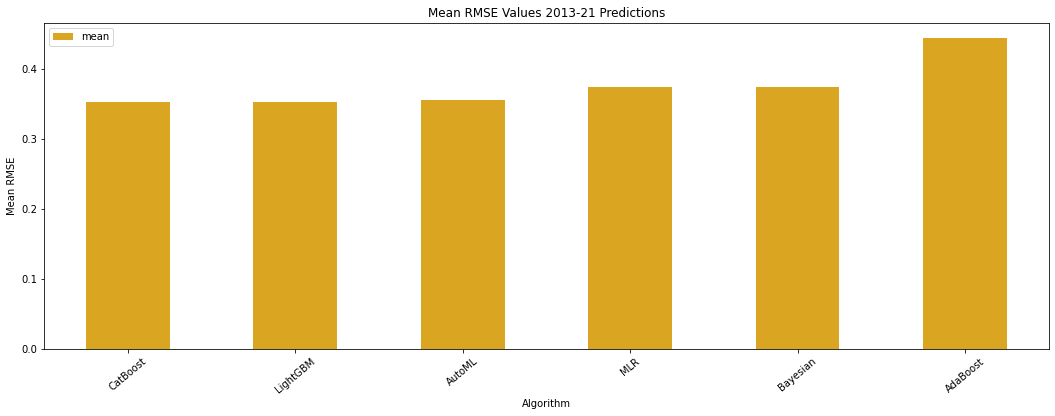

In [261]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Mean RMSE', title='Mean RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MEDAE'>

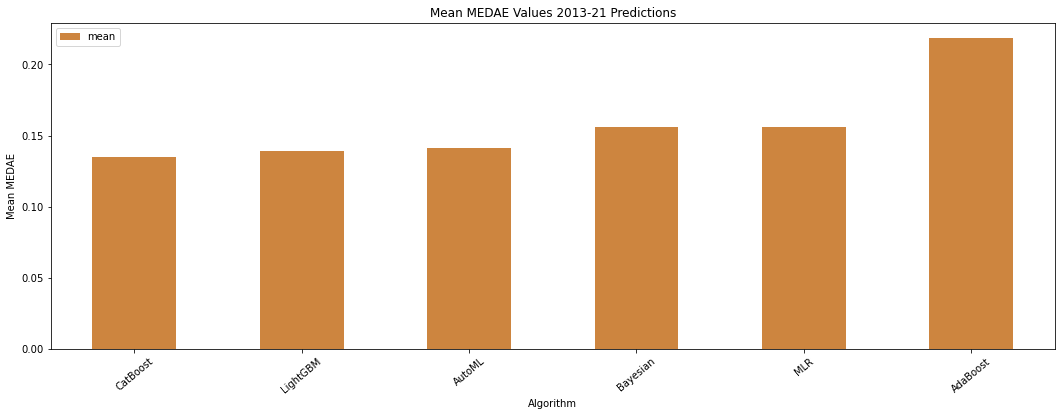

In [262]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Mean MEDAE', title='Mean MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

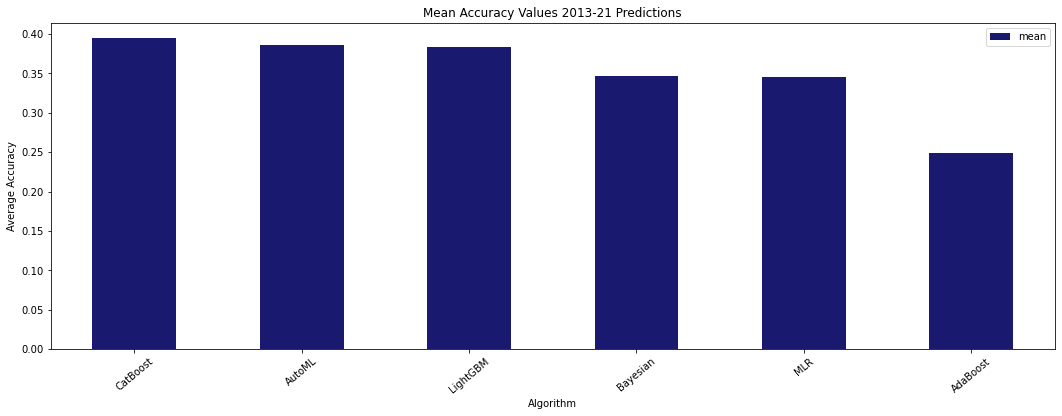

In [263]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum', 'min']})
grouped_multiple3.columns = ['mean','median','max','sum', 'min']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MSE'>

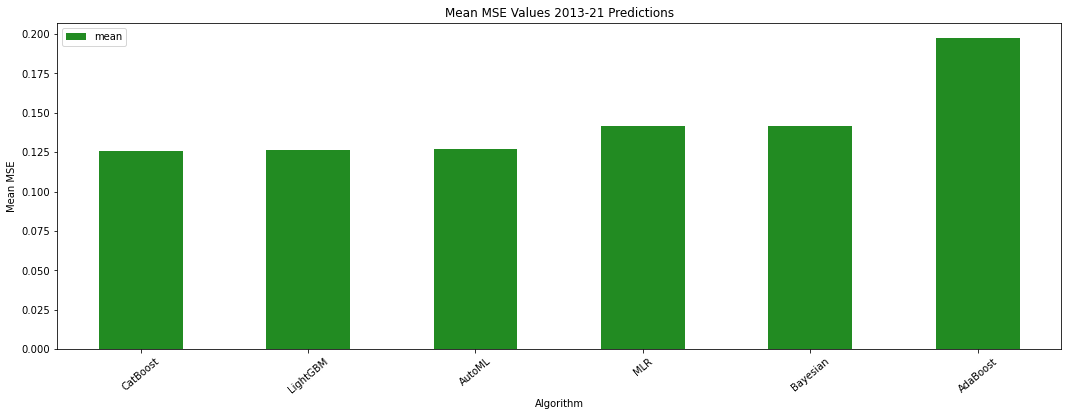

In [264]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Mean MSE', title='Mean MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

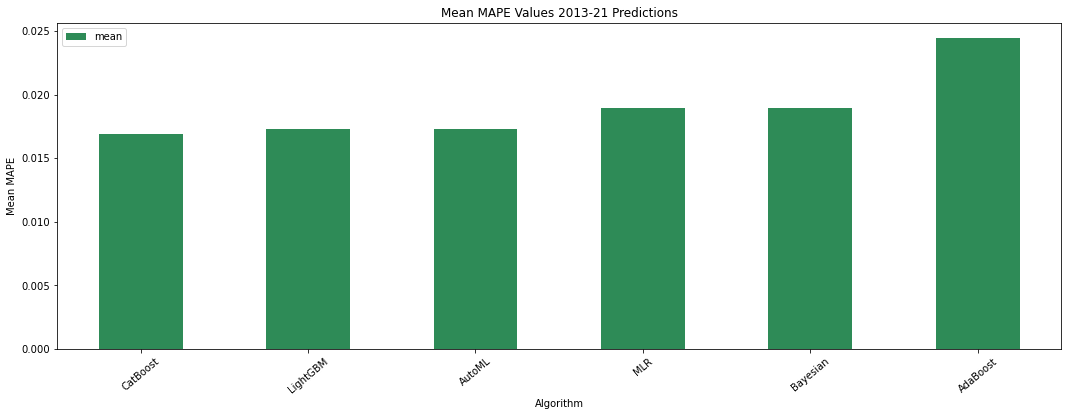

In [265]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

Result that can be compared around 6/7 % off [this](https://arxiv.org/pdf/2108.09175.pdf), (slightly diff approach taken by me predicting yearly however!)

In [266]:
grouped_multiple3.sort_values(by = 'mean', ascending = False)

,Algorithm,mean,median,max,sum,min
3,CatBoost,0.394423,0.399706,0.411246,1.972115,0.363047
1,AutoML,0.386041,0.387705,0.406630,1.930206,0.357761
4,LightGBM,0.383833,0.388060,0.399916,1.919166,0.346228
2,Bayesian,0.346256,0.347539,0.356693,1.731281,0.331571
5,MLR,0.346112,0.345089,0.359421,1.730561,0.331812
0,AdaBoost,0.249082,0.260103,0.270667,1.245411,0.195339


<AxesSubplot:title={'center':'Performance of ML algorithms accuracy from 2017-2021 Predictions'}, xlabel='Year'>

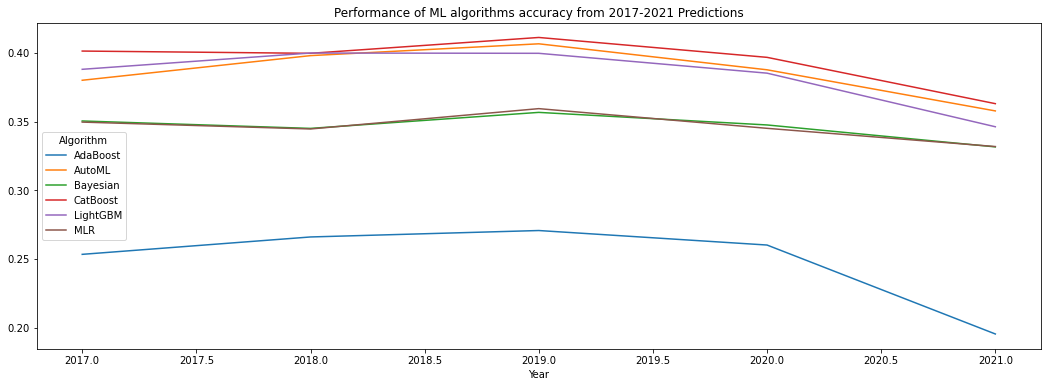

In [267]:
# yearly accuracy results
df = vis2.pivot(index = 'Year', columns = 'Algorithm', values = 'Accuracy')
df.plot(figsize = (18, 6), title = 'Performance of ML algorithms accuracy from 2017-2021 Predictions')

## Little over 2% improvement on default implementation with same libraries

Pitch data improves by 0.2% more.

To do:

- TPOT AutoML and SHAP